In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
# client = MongoClient("mongodb://13.127.57.185:27017/")
# client.list_database_names()
# db = client['pvvnl']
# db.list_collection_names()
# collection = db["load_profile_jdvvnl"]
# data = collection.find({'sensor_id': '0000e2fc-8dad-4d82-9da6-88695cc94265'})
# l = []
# for _ in data:
#     l.append(_)
#     # print(_)
# df = pd.DataFrame(l)
# df

In [3]:
df = pd.read_csv("single_feeder_data_jdvvnl.csv", low_memory=False)
df = df[['sensor_id', 'instant_cum_KW', 'instant_cum_KVA', 'R_Voltage',
       'Y_Voltage', 'B_Voltage', 'R_Current', 'Y_Current', 'B_Current', 'R_PF',
       'Y_PF', 'B_PF', 'cumm_PF', 'status', 'date',
       'creation_time', 'opening_KWh', 'opening_KVAh', 'closing_KWh',
       'closing_KVAh', 'count'
       ]]
dff = df[df['status']=="P"]
cols_to_divide = ['instant_cum_KW', 'instant_cum_KVA', 'R_Voltage', 'Y_Voltage', 'B_Voltage', 
                  'R_Current', 'Y_Current', 'B_Current', 'R_PF', 'Y_PF', 'B_PF', 'cumm_PF']

# Ensure you're using .loc to modify the original dataframe
dff.loc[:, cols_to_divide] = dff[cols_to_divide].apply(lambda x: x / dff['count'], axis=0)
data = dff[["creation_time",'instant_cum_KW']]
data.reset_index(drop=True ,inplace=True)
data = data.copy()  # Create a copy
data.rename(columns={"instant_cum_KW":'Load_kW'},inplace=True)
data['creation_time'] = pd.to_datetime(data['creation_time'])
data.set_index('creation_time',drop=True,inplace=True)
data = data.loc[data.index>pd.to_datetime("2023-10-01 00:00:00")]
data

,Load_kW
creation_time,
2023-10-01 00:15:00,19.9233
2023-10-01 00:30:00,19.9911
2023-10-01 00:45:00,19.7322
2023-10-01 01:00:00,20.2622
2023-10-01 01:15:00,19.8744
...,...
2024-03-30 22:45:00,10.4722
2024-03-30 23:00:00,10.3067
2024-03-30 23:15:00,10.0856


at start:  Load_kW    1937
dtype: int64
at end:  Load_kW    0
dtype: int64


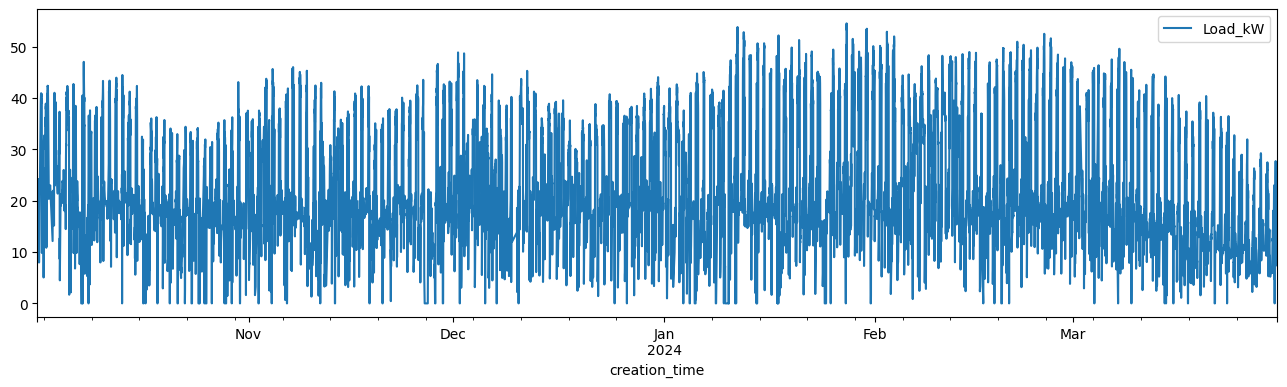

,Load_kW
creation_time,
2023-10-01 00:15:00,19.9233
2023-10-01 00:30:00,19.9911
2023-10-01 00:45:00,19.7322
2023-10-01 01:00:00,20.2622
2023-10-01 01:15:00,19.8744
...,...
2024-03-30 22:45:00,10.4722
2024-03-30 23:00:00,10.3067
2024-03-30 23:15:00,10.0856


In [4]:
resample_df = data.resample(rule="15 min").asfreq()
print("at start: ",resample_df.isna().sum())
# Fill NaN values in each column with the mean of that column
# resample_df = resample_df.fillna(resample_df.mean())
resample_df.interpolate(method="linear", inplace=True)
print("at end: ",resample_df.isna().sum())
plt.figure(figsize=(16, 4))
resample_df.plot(ax=plt.gca())  # This uses the current axes
# plt.title(col)
plt.show()
resample_df

In [5]:
# from logger import logger
# import requests
# from datetime import datetime

# def weather_data_api(latitude, longitude, from_date, to_date, duration="hour"):
#         try:
#             url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={from_date}&end_date={to_date}&hourly=temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,wind_speed_10m,wind_speed_100m"
#             logger.info(f"weather api url : {url}")
#             response = requests.get(url)
#             response.raise_for_status()
#             weather_data = response.json()
        
#             # for i in range(len(weather_data['hourly']['time'])):
#             #                 hour_data = {
#             #     # "_id": f"{site_data['_id']}_{weather_data['hourly']['time'][i]}",  # MongoDB's unique identifier
#             #     # "site_id": site_data["_id"],
#             #     "time": weather_data['hourly']['time'][i],
#             #     "temperature_2m": weather_data['hourly'].get('temperature_2m', [])[i],
#             #     "relative_humidity_2m": weather_data['hourly'].get('relative_humidity_2m', [])[i],
#             #     "apparent_temperature": weather_data['hourly'].get('apparent_temperature', [])[i],
#             #     # "precipitation": weather_data['hourly'].get('precipitation', [])[i],
#             #     "wind_speed_10m": weather_data['hourly'].get('wind_speed_10m', [])[i],
#             #     # "wind_speed_100m": weather_data['hourly'].get('wind_speed_100m', [])[i],
#             #     "creation_time_iso": datetime.utcfromtimestamp(
#             #         datetime.strptime(weather_data['hourly']['time'][i],
#             #                             '%Y-%m-%dT%H:%M').timestamp()).isoformat()
#             # }
#             weather_df = pd.DataFrame({
#                                     'time': weather_data['hourly']['time'],
#                                     'apparent_temperature': weather_data['hourly']['apparent_temperature'],
#                                     'rain': weather_data['hourly']['rain'],
#                                     'wind_speed_10m': weather_data['hourly']['wind_speed_10m']
#                                 })
#             weather_df['time'] = pd.to_datetime(weather_df['time'])
#             weather_df.rename(columns={"time":"creation_time"}, inplace=True)
#             weather_df.set_index("creation_time",inplace=True,drop=True)
#             logger.info(f"weather data:{len(weather_df)} ")

#             if duration != "hour":
#                 resampled_df = weather_df.resample(rule=duration).ffill()
#                 resampled_df.reset_index(inplace=True)
#                 return resampled_df
#             logger.info(f"weather data done")
#             return weather_df
                
#         except Exception as e:
#                 logger.info(f"error in weather data: {e}",exc_info=True)


# weather_df = weather_data_api(latitude,longitude,from_date,to_date,duration="15min")
# weather_df

from_date:  2023-10-01 to_date:  2024-03-30
holidays_lst: [datetime.date(2023, 10, 1), datetime.date(2023, 10, 2), datetime.date(2023, 10, 8), datetime.date(2023, 10, 15), datetime.date(2023, 10, 22), datetime.date(2023, 10, 29), datetime.date(2023, 11, 5), datetime.date(2023, 11, 12), datetime.date(2023, 11, 19), datetime.date(2023, 11, 26), datetime.date(2023, 12, 3), datetime.date(2023, 12, 10), datetime.date(2023, 12, 17), datetime.date(2023, 12, 24), datetime.date(2023, 12, 25), datetime.date(2023, 12, 31), datetime.date(2024, 1, 7), datetime.date(2024, 1, 14), datetime.date(2024, 1, 21), datetime.date(2024, 1, 26), datetime.date(2024, 1, 28), datetime.date(2024, 2, 4), datetime.date(2024, 2, 11), datetime.date(2024, 2, 18), datetime.date(2024, 2, 25), datetime.date(2024, 3, 3), datetime.date(2024, 3, 10), datetime.date(2024, 3, 17), datetime.date(2024, 3, 24), datetime.date(2024, 3, 25), datetime.date(2024, 3, 29)]


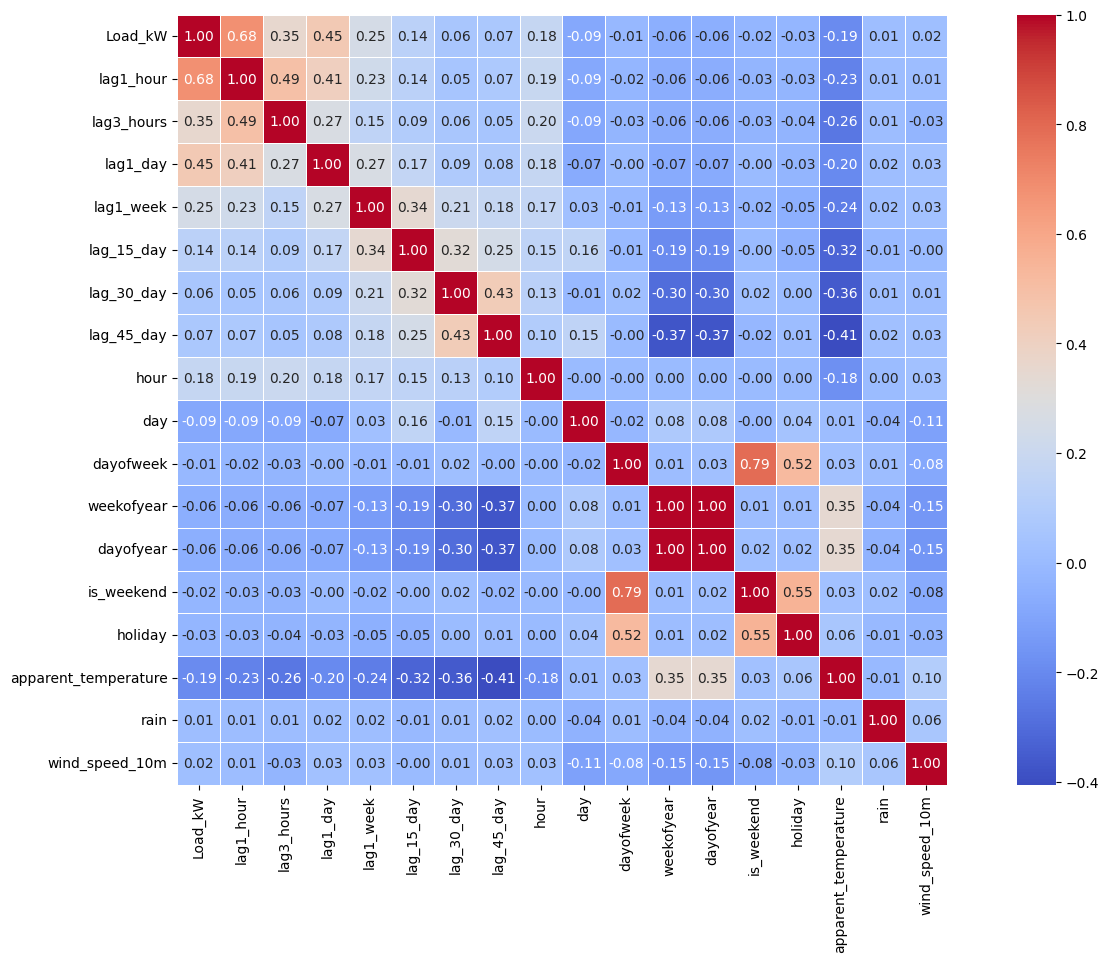

,Load_kW,lag1_hour,lag3_hours,lag1_day,lag1_week,lag_15_day,lag_30_day,lag_45_day,hour,day,dayofweek,weekofyear,dayofyear,is_weekend,holiday,apparent_temperature,rain,wind_speed_10m
0,19.9233,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,6,39,274,1,1,25.6000,0.0000,8.0000
1,19.9911,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,6,39,274,1,1,25.6000,0.0000,8.0000
2,19.7322,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,6,39,274,1,1,25.6000,0.0000,8.0000
3,20.2622,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,6,39,274,1,1,26.2000,0.0000,7.6000
4,19.8744,19.9233,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,6,39,274,1,1,26.2000,0.0000,7.6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17463,10.7222,12.0229,7.3756,8.6475,10.1411,11.8656,16.2156,17.0456,22,30,5,13,90,1,0,20.1000,0.0000,6.8000
17464,10.0433,12.8400,10.5589,7.4969,9.9933,11.7286,18.1967,15.9422,22,30,5,13,90,1,0,20.1000,0.0000,6.8000
17465,10.5167,12.3656,11.4844,6.3462,9.9178,11.2280,19.4878,16.1611,22,30,5,13,90,1,0,20.1000,0.0000,6.8000
17466,10.4722,11.6033,12.1789,5.1956,10.4311,10.7275,19.1189,15.8344,22,30,5,13,90,1,0,20.1000,0.0000,6.8000


In [6]:
from common_functions import NPCL, common
npcl_obj = NPCL()
common_obj  = common()
# df1 = common_obj.add_lags(resample_df,target_col="Load_kW")
# df2 = common_obj.create_features(df1)

latitude, longitude = "28.625361","77.376214"#, 28.628059,77.378912
from_date = resample_df.first_valid_index().date()
to_date = resample_df.last_valid_index().date()
print("from_date: ",from_date,"to_date: ",to_date)
weather_df = npcl_obj.weather_data_api(latitude,longitude,from_date,to_date,duration="15min")

holidays_lst= common_obj.holidays_list(from_date,to_date)
print("holidays_lst:",holidays_lst)

df_lags = common_obj.add_lags(resample_df,target_col="Load_kW",large_data=True)
df2 = common_obj.create_features(df_lags)
for date in holidays_lst:
    df2.loc[f"{date}", 'holiday'] = 1
df2.fillna(0,inplace= True)
df3 = df2.merge(weather_df,on=["creation_time"])
df3.drop(['creation_time'],axis=1,inplace=True)
common_obj.correlation_matrix(df3)
df3

In [7]:
# target_variable = "Load_kW"
# dataset_scalled = common_obj.scaling_layer(datset=df3)
# train_features, test_features = common_obj.data_split_function(dataset=dataset_scalled)
# train_labels = train_features.pop(target_variable)
# test_labels = test_features.pop(target_variable)

In [8]:
# train_features

In [9]:
train_dataset, test_dataset = common_obj.data_split_function(dataset=df3)
train_dataset

,Load_kW,lag1_hour,lag3_hours,lag1_day,lag1_week,lag_15_day,lag_30_day,lag_45_day,hour,day,dayofweek,weekofyear,dayofyear,is_weekend,holiday,apparent_temperature,rain,wind_speed_10m
0,19.9233,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,6,39,274,1,1,25.6000,0.0000,8.0000
1,19.9911,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,6,39,274,1,1,25.6000,0.0000,8.0000
2,19.7322,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,6,39,274,1,1,25.6000,0.0000,8.0000
3,20.2622,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,6,39,274,1,1,26.2000,0.0000,7.6000
4,19.8744,19.9233,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,6,39,274,1,1,26.2000,0.0000,7.6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15716,4.3970,39.2647,29.3464,35.2967,44.6638,49.8556,25.4533,50.3978,17,12,1,11,72,0,0,18.0000,0.0000,17.9000
15717,29.5125,40.5044,30.5861,39.9800,41.8633,50.8578,21.4100,49.0733,17,12,1,11,72,0,0,18.0000,0.0000,17.9000
15718,38.1088,43.6170,31.8259,41.5622,41.8456,50.0922,14.6411,46.9589,17,12,1,11,72,0,0,18.0000,0.0000,17.9000
15719,42.7400,44.2989,33.0657,42.4311,9.2344,51.6556,21.9550,48.5150,18,12,1,11,72,0,0,17.6000,0.0000,15.5000



Model Power Evaluation
Mean Squared Error (MSE): 77.58712207160787
Mean Absolute Error (MAE): 5.985249389019619
R-squared: 0.4069226159966889


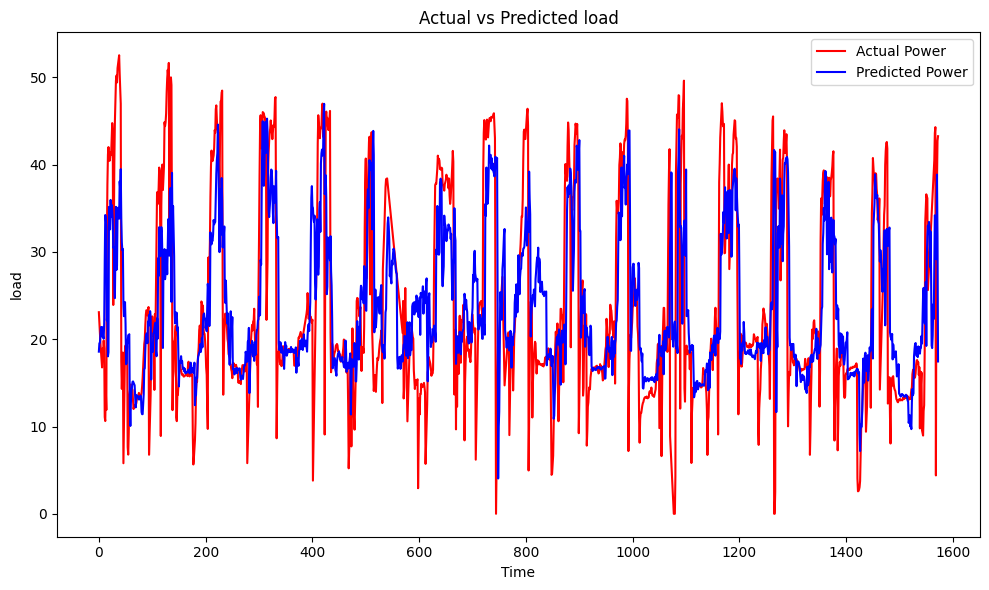

In [10]:
model = common_obj.model_trainer(train_dataset,target_variable="Load_kW",model_name= "RFR")

In [25]:
def feature_label_extraction(self,dataset,target_variable):
    try:
        dataset_features = dataset.copy()
        dataset_label = dataset_features.pop(target_variable)
        return dataset_features, dataset_label
    except Exception as e:
        logger.info("error in feature label extraction",exc_info= True)
test_label = test_dataset.pop("Load_kW")


Model Power Evaluation
Mean Squared Error (MSE): 110.03873322617183
Mean Absolute Error (MAE): 7.077976285527735
R-squared: -0.39181378074876183


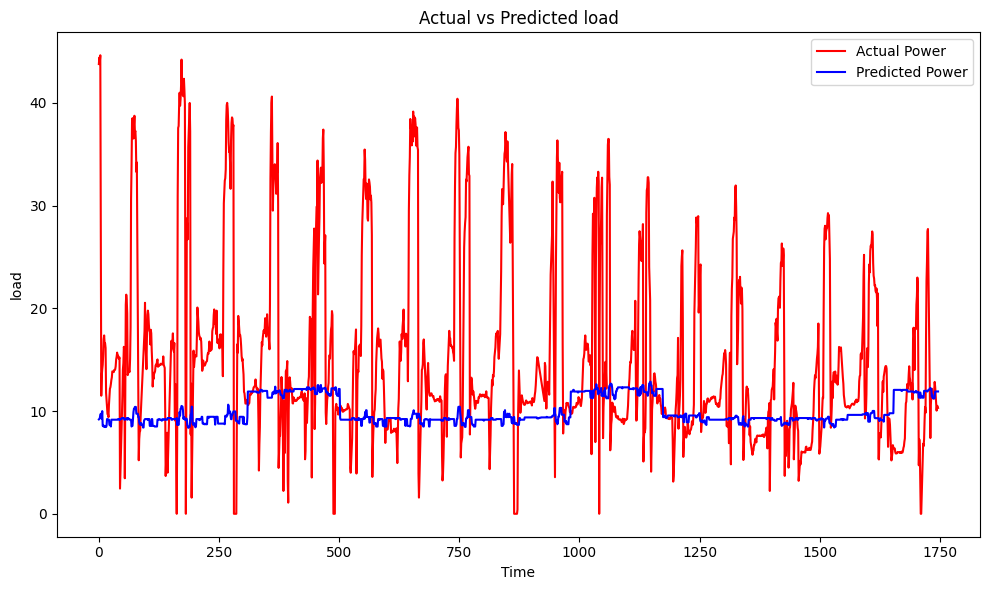

array([ 9.19 ,  9.234,  9.329, ..., 11.906, 11.906, 11.906])

In [26]:
common_obj.prediction(model,test_dataset,scoring=True,test_data=test_label,prediction=True)

In [9]:
import numpy as np

df4 = df3.copy()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_to_normalize = ['lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours',
       'lag12_hours', 'lag1_day', 'lag1_week', 'lag_15_day', 'lag_30_day',
       'lag_45_day', 'hour', 'day', 'dayofweek', 'weekofyear', 'dayofyear',
       'is_weekend', 'holiday', 'temperature_2m', 'relative_humidity_2m',
       'apparent_temperature', 'precipitation', 'rain', 'wind_speed_10m',
       'wind_speed_100m']
df4[features_to_normalize] = scaler.fit_transform(df4[features_to_normalize])

df4['hour_sin'] = np.sin(2 * np.pi * df4['hour'] / 24)
df4['hour_cos'] = np.cos(2 * np.pi * df4['hour'] / 24)
df4['day_sin'] = np.sin(2 * np.pi * df4['day'] / 31)  # Assuming day is between 1-31
df4['day_cos'] = np.cos(2 * np.pi * df4['day'] / 31)
df4

,Load_kW,lag1_hour,lag2_hours,lag3_hours,lag6_hours,lag12_hours,lag1_day,lag1_week,lag_15_day,lag_30_day,lag_45_day,hour,day,dayofweek,weekofyear,dayofyear,is_weekend,holiday,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,wind_speed_10m,wind_speed_100m,hour_sin,hour_cos,day_sin,day_cos
0,8.9100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4783,0.4000,0.5000,0.5294,0.5302,0.0000,0.0000,0.8208,0.6543,0.8440,0.1832,0.1832,0.4071,0.3632,0.1249,0.9922,0.0810,0.9967
1,9.9363,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4783,0.4000,0.5000,0.5294,0.5302,0.0000,0.0000,0.8208,0.6543,0.8440,0.1832,0.1832,0.4071,0.3632,0.1249,0.9922,0.0810,0.9967
2,12.7100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5217,0.4000,0.5000,0.5294,0.5302,0.0000,0.0000,0.8035,0.6914,0.8463,0.1679,0.1679,0.2920,0.2778,0.1362,0.9907,0.0810,0.9967
3,15.5560,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5217,0.4000,0.5000,0.5294,0.5302,0.0000,0.0000,0.8035,0.6914,0.8463,0.1679,0.1679,0.2920,0.2778,0.1362,0.9907,0.0810,0.9967
4,15.0633,0.1633,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5217,0.4000,0.5000,0.5294,0.5302,0.0000,0.0000,0.8035,0.6914,0.8463,0.1679,0.1679,0.2920,0.2778,0.1362,0.9907,0.0810,0.9967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25098,10.7222,0.2203,0.2157,0.1352,0.1665,0.3120,0.1585,0.1859,0.2175,0.2972,0.3124,0.9565,0.9667,0.8333,0.2353,0.2445,1.0000,0.0000,0.5116,0.4568,0.4586,0.0000,0.0000,0.2006,0.2201,0.2478,0.9688,0.1947,0.9809
25099,10.0433,0.2353,0.2159,0.1935,0.1907,0.3319,0.1374,0.1831,0.2149,0.3335,0.2922,0.9565,0.9667,0.8333,0.2353,0.2445,1.0000,0.0000,0.5116,0.4568,0.4586,0.0000,0.0000,0.2006,0.2201,0.2478,0.9688,0.1947,0.9809
25100,10.5167,0.2266,0.2073,0.2105,0.1802,0.3164,0.1163,0.1818,0.2058,0.3571,0.2962,0.9565,0.9667,0.8333,0.2353,0.2445,1.0000,0.0000,0.5116,0.4568,0.4586,0.0000,0.0000,0.2006,0.2201,0.2478,0.9688,0.1947,0.9809
25101,10.4722,0.2126,0.2053,0.2232,0.3150,0.2565,0.0952,0.1912,0.1966,0.3504,0.2902,0.9565,0.9667,0.8333,0.2353,0.2445,1.0000,0.0000,0.5116,0.4568,0.4586,0.0000,0.0000,0.2006,0.2201,0.2478,0.9688,0.1947,0.9809



Model Power Evaluation
Mean Squared Error (MSE): 29.52645407139842
Mean Absolute Error (MAE): 2.995644762283601
R-squared: 0.7816427841813449


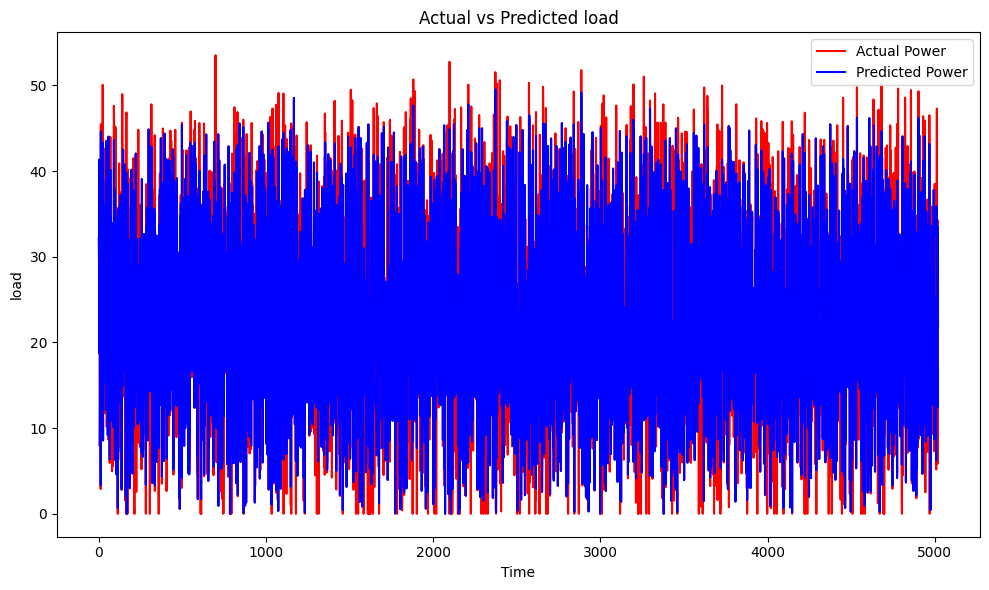

In [10]:

model = common_obj.model_trainer(df4)